In [1]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown


import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Test

In [2]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."

files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report_path = path.join("reports", last_experiment.replace(".yaml",".yaml"))
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not None, "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not None, "No interactions found."
assert report.interactions[0] is not None, "No interactions found. "
assert report.interactions[0].response_data is not None, "No data in interaction found"


Loaded report report_2024-11-27_13-40-41.yaml


In [3]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_kepler_pods = []
cached_dataframes_kepler_namespace = []

Loading some basic functions used later on

In [4]:

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    print(interaction)
                    print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    interaction.response_data["label"] = f"{REPORT_LABELS[report_name]}"

                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time

def plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time):

        # Normalize t0 and t1 to seconds relative to treatment start time
        treatment_start_seconds = 0  # t0 is always 0 after normalization
        treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

        # Get unique container names
        container_names = combined_df["container_name"].unique()

        # Determine the grid size for subplots
        num_containers = len(container_names)
        num_cols = 2  # Define the number of columns for the grid
        num_rows = ceil(num_containers / num_cols)

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
        axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

        # Plot the data for each container_name in a subplot
        for idx, container_name in enumerate(container_names):
            ax = axes[idx]
            assert isinstance(ax, plt.Axes)
            container_df = combined_df[combined_df["container_name"] == container_name]

            for treatment, df in container_df.groupby("treatment"):
                print(df["experiment_seconds"])
                ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

            # Add vertical lines for treatment start and end times (normalized)
            ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
            ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

            ax.set_title(f"Container: {container_name}")
            ax.set_xlabel("Time (seconds from experiment start)")
            ax.set_ylabel(response_name)
            ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
            ax.legend()
            ax.grid()

        # Hide any unused subplots
        for idx in range(num_containers, len(axes)):
            fig.delaxes(axes[idx])

        # Adjust layout
        plt.tight_layout()
        plt.show()
        
def plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(6, 6))

    

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]

    print(namespace_df)

    for treatment, df in namespace_df.groupby("treatment"):
        print(df["experiment_seconds"])
        ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from experiment start)")
    ax.set_ylabel(response_name)
    #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
    ax.legend()
    ax.grid()

    
    # Adjust layout
    plt.tight_layout()
    plt.show()
   

In [5]:
# uncomment to reset cache
cached_dataframes_kepler_namespace = []


# Directory containing reports
report_directory = "reports"
treatment_names = ["delay_treatment", "empty_treatment"]
#                       baseline                            delay 1m                            delay 1s                        5% base                         5% delay                                   10% base                             10% delay
report_names = ["report_2024-11-25_18-12-29.yaml", "report_2024-11-25_18-42-06.yaml", "report_2024-11-25_19-11-46.yaml", "report_2024-11-25_19-41-37.yaml", "report_2024-11-25_20-11-42.yaml",  "report_2024-11-25_20-41-35.yaml", "report_2024-11-25_21-11-26.yaml"]
REPORT_LABELS = {report_names[0]: "Baseline", report_names[1]: "Delay 1m", report_names[2]: "Delay 1s", report_names[3]: "5% Base", report_names[4]: "5% Delay", report_names[5]: "10% Base", report_names[6]: "10% Delay"}


response_name_storage_namespace_combined_absolute = "cadvisor_storage_usage_combined_absolute"


# Storage Energy

In [6]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_delay = load_report_interactions(report_directory, report_names[1], response_name_storage_namespace_combined_absolute, "delay_treatment")
report_delay_1s = load_report_interactions(report_directory, report_names[2], response_name_storage_namespace_combined_absolute, "delay_treatment")
report_sampling_5_percent = load_report_interactions(report_directory, report_names[3], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_delay_5_percent = load_report_interactions(report_directory, report_names[4], response_name_storage_namespace_combined_absolute, "delay_treatment")
report_base_10_percent = load_report_interactions(report_directory, report_names[5], response_name_storage_namespace_combined_absolute, "empty_treatment")
report_delay_10_percent = load_report_interactions(report_directory, report_names[6], response_name_storage_namespace_combined_absolute, "delay_treatment")

[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVari

In [7]:
def get_storage_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    for container_namespace, df in interaction.response_data.groupby("container_label_io_kubernetes_pod_namespace"):
        treatment_df = df[df[treatment_name] == treatment_name]
        if not treatment_df.empty:
            # get the first and last value of the treatment
            treatment_start = treatment_df[response_name_storage_namespace_combined_absolute].iloc[0]
            treatment_end = treatment_df[response_name_storage_namespace_combined_absolute].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_namespace] = (treatment_start, treatment_end, difference)
    return treatment_start_end_values

treatment_start_end = {}

report_base_storage_namespace = get_storage_energy_consumption(report_base, "empty_treatment")
report_delay_storage_namespace = get_storage_energy_consumption(report_delay, "delay_treatment")
report_delay_1s_storage_namespace = get_storage_energy_consumption(report_delay_1s, "delay_treatment")
report_sampling_5_percent_storage_namespace = get_storage_energy_consumption(report_sampling_5_percent, "empty_treatment")
report_delay_5_percent_storage_namespace = get_storage_energy_consumption(report_delay_5_percent, "delay_treatment")
report_base_10_percent_storage_namespace = get_storage_energy_consumption(report_base_10_percent, "empty_treatment")
report_delay_10_percent_storage_namespace = get_storage_energy_consumption(report_delay_10_percent, "delay_treatment")

for container_namespace, values in report_base_storage_namespace.items():
    percentage_differece_delay = (report_delay_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_delay_1s = (report_delay_1s_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_sampling = (report_sampling_5_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_delay_5_percent = (report_delay_5_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_difference_base_10_percent = (report_base_10_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    percentage_differece_delay_10_percent = (report_delay_10_percent_storage_namespace[container_namespace][2] - report_base_storage_namespace[container_namespace][2]) / report_base_storage_namespace[container_namespace][2] * 100
    print(f"Namespace: {container_namespace}")
    print(f"Base Treatment: {report_base_storage_namespace[container_namespace][2]}")
    print(f"Delay Treatment: {report_delay_storage_namespace[container_namespace][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {report_delay_1s_storage_namespace[container_namespace][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"Sampling 5% Treatment: {report_sampling_5_percent_storage_namespace[container_namespace][2]} ({percentage_differece_sampling:.2f}%)")
    print(f"Delay 5% Treatment: {report_delay_5_percent_storage_namespace[container_namespace][2]} ({percentage_differece_delay_5_percent:.2f}%)")
    print(f"Base 10% Treatment: {report_base_10_percent_storage_namespace[container_namespace][2]} ({percentage_difference_base_10_percent:.2f}%)")
    print(f"Delay 10% Treatment: {report_delay_10_percent_storage_namespace[container_namespace][2]} ({percentage_differece_delay_10_percent:.2f}%)")
    
    print("-----------------------------------------------")

Namespace: system-under-evaluation
Base Treatment: 205053952
Delay Treatment: 204021760 (-0.50%)
Delay 1s Treatment: 205971456 (0.45%)
Sampling 5% Treatment: 212844544 (3.80%)
Delay 5% Treatment: 207044608 (0.97%)
Base 10% Treatment: 207568896 (1.23%)
Delay 10% Treatment: 210018304 (2.42%)
-----------------------------------------------


In [9]:
report_base_storage_per_pod = load_report_interactions(report_directory, report_names[0], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_delay_storage_per_pod = load_report_interactions(report_directory, report_names[1], "cadvisor_storage_usage_all_absolute", "delay_treatment")
report_delay_1s_storage_per_pod = load_report_interactions(report_directory, report_names[2], "cadvisor_storage_usage_all_absolute", "delay_treatment")
report_sampling_5_percent_storage_per_pod = load_report_interactions(report_directory, report_names[3], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_delay_5_percent_storage_per_pod = load_report_interactions(report_directory, report_names[4], "cadvisor_storage_usage_all_absolute", "delay_treatment")
report_base_10_percent_storage_per_pod = load_report_interactions(report_directory, report_names[5], "cadvisor_storage_usage_all_absolute", "empty_treatment")
report_delay_10_percent_storage_per_pod = load_report_interactions(report_directory, report_names[6], "cadvisor_storage_usage_all_absolute", "delay_treatment")

[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVari

In [10]:
def get_storage_energy_consumption_per_pod(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["container_label_io_kubernetes_container_name"].unique())
    print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("container_label_io_kubernetes_container_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]

        # cut off the first and last 10% of the data
        treatment_df = df.iloc[int(len(df) * 0.1):int(len(df) * 0.9)]
    
        
        if not treatment_df.empty:
            # TODO: use increase() in prometheus query instead of fixing it here
            # the values are normally monotonic increasing, but there are some exceptions where the values resets to 0 and starts again
            # so we have to check if each following value is greater than the previous one and if not, then we have to add the difference
            
            # Extract the column into a separate series to avoid chained assignment
            column = treatment_df["cadvisor_storage_usage_all_absolute"].copy()

            # Iterate through the series to fix monotonicity
            for i in range(1, len(column)):
                if column.iloc[i] < column.iloc[i - 1]:
                    print(f"Container: {container_name}, Found break in monotonicity at index {i}. Fixing it.")
                    # Calculate the difference and propagate it to all subsequent values
                    difference = column.iloc[i - 1] - column.iloc[i]
                    column.iloc[i:] += difference

            # Assign the fixed series back to the DataFrame
            treatment_df["cadvisor_storage_usage_all_absolute"] = column
            
            
            # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_storage_usage_all_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_storage_usage_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")
            # set to 0 if no treatment period found
            treatment_start_end_values[container_name] = (-1, -1, -1)

    return treatment_start_end_values

values_base_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_storage_per_pod, "empty_treatment")
values_delay_storage_per_pod = get_storage_energy_consumption_per_pod(report_delay_storage_per_pod, "delay_treatment")
values_delay_1s_storage_per_pod = get_storage_energy_consumption_per_pod(report_delay_1s_storage_per_pod, "delay_treatment")
values_sampling_5_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_sampling_5_percent_storage_per_pod, "empty_treatment")
values_delay_5_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_delay_5_percent_storage_per_pod, "delay_treatment")
values_base_10_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_base_10_percent_storage_per_pod, "empty_treatment")
values_delay_10_percent_storage_per_pod = get_storage_energy_consumption_per_pod(report_delay_10_percent_storage_per_pod, "delay_treatment")


for container_name, values in values_base_storage_per_pod.items():
    if not container_name in values_delay_storage_per_pod or not container_name in values_delay_1s_storage_per_pod or not container_name in values_sampling_5_percent_storage_per_pod:
        print(f"Container {container_name} not found in all treatments.")
        continue
    percentage_differece_delay = (values_delay_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_delay_1s = (values_delay_1s_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_sampling = (values_sampling_5_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_delay_5_percent = (values_delay_5_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_difference_base_10_percent = (values_base_10_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    percentage_differece_delay_10_percent = (values_delay_10_percent_storage_per_pod[container_name][2] - values_base_storage_per_pod[container_name][2]) / values_base_storage_per_pod[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {values_base_storage_per_pod[container_name][2]}")
    print(f"Delay Treatment: {values_delay_storage_per_pod[container_name][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {values_delay_1s_storage_per_pod[container_name][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"Sampling 5% Treatment: {values_sampling_5_percent_storage_per_pod[container_name][2]} ({percentage_differece_sampling:.2f}%)")
    print(f"Delay 5% Treatment: {values_delay_5_percent_storage_per_pod[container_name][2]} ({percentage_differece_delay_5_percent:.2f}%)")
    print(f"Base 10% Treatment: {values_base_10_percent_storage_per_pod[container_name][2]} ({percentage_difference_base_10_percent:.2f}%)")
    print(f"Delay 10% Treatment: {values_delay_10_percent_storage_per_pod[container_name][2]} ({percentage_differece_delay_10_percent:.2f}%)")
    print("-----------------------------------------------")

# sum up the values for all containers for each different report
sum_base = sum([values_base_storage_per_pod[container_name][2] for container_name in values_base_storage_per_pod])
sum_delay = sum([values_delay_storage_per_pod[container_name][2] for container_name in values_delay_storage_per_pod])
sum_delay_1s = sum([values_delay_1s_storage_per_pod[container_name][2] for container_name in values_delay_1s_storage_per_pod])
sum_sampling_5_percent = sum([values_sampling_5_percent_storage_per_pod[container_name][2] for container_name in values_sampling_5_percent_storage_per_pod])
sum_delay_5_percent = sum([values_delay_5_percent_storage_per_pod[container_name][2] for container_name in values_delay_5_percent_storage_per_pod])
sum_base_10_percent = sum([values_base_10_percent_storage_per_pod[container_name][2] for container_name in values_base_10_percent_storage_per_pod])
sum_delay_10_percent = sum([values_delay_10_percent_storage_per_pod[container_name][2] for container_name in values_delay_10_percent_storage_per_pod])

percentage_differece_delay = (sum_delay - sum_base) / sum_base * 100
percentage_differece_delay_1s = (sum_delay_1s - sum_base) / sum_base * 100
percentage_differece_sampling = (sum_sampling_5_percent - sum_base) / sum_base * 100
percentage_differece_delay_5_percent = (sum_delay_5_percent - sum_base) / sum_base * 100
percentage_difference_base_10_percent = (sum_base_10_percent - sum_base) / sum_base * 100
percentage_differece_delay_10_percent = (sum_delay_10_percent - sum_base) / sum_base * 100

print(f"Sum of all containers")
print(f"Base Treatment: {sum_base}")
print(f"Delay Treatment: {sum_delay} ({percentage_differece_delay:.2f}%)")
print(f"Delay 1s Treatment: {sum_delay_1s} ({percentage_differece_delay_1s:.2f}%)")
print(f"Sampling 5% Treatment: {sum_sampling_5_percent} ({percentage_differece_sampling:.2f}%)")
print(f"Delay 5% Treatment: {sum_delay_5_percent} ({percentage_differece_delay_5_percent:.2f}%)")
print(f"Base 10% Treatment: {sum_base_10_percent} ({percentage_difference_base_10_percent:.2f}%)")
print(f"Delay 10% Treatment: {sum_delay_10_percent} ({percentage_differece_delay_10_percent:.2f}%)")
print("-----------------------------------------------")




Interaction: empty_treatment with 16 containers
Interaction: delay_treatment with 16 containers
Container: recommendationservice, Found break in monotonicity at index 7. Fixing it.
Interaction: delay_treatment with 17 containers
Container: recommendationservice, Found break in monotonicity at index 7. Fixing it.
Interaction: empty_treatment with 16 containers
Container: opentelemetry-collector, Found break in monotonicity at index 7. Fixing it.
Interaction: delay_treatment with 17 containers
Container: recommendationservice, Found break in monotonicity at index 8. Fixing it.
Interaction: empty_treatment with 16 containers


/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Container: opentelemetry-collector, Found break in monotonicity at index 34. Fixing it.
Interaction: delay_treatment with 16 containers
Container: recommendationservice, Found break in monotonicity at index 7. Fixing it.
Container: accountingservice
Base Treatment: 6635520
Delay Treatment: 6553600 (-1.23%)
Delay 1s Treatment: 6561792 (-1.11%)
Sampling 5% Treatment: 6717440 (1.23%)
Delay 5% Treatment: 6676480 (0.62%)
Base 10% Treatment: 6635520 (0.00%)
Delay 10% Treatment: 6619136 (-0.25%)
-----------------------------------------------
Container: adservice
Base Treatment: 7421952
Delay Treatment: 7446528 (0.33%)
Delay 1s Treatment: 7716864 (3.97%)
Sampling 5% Treatment: 7544832 (1.66%)
Delay 5% Treatment: 7815168 (5.30%)
Base 10% Treatment: 7643136 (2.98%)
Delay 10% Treatment: 7553024 (1.77%)
-----------------------------------------------
Container: emailservice
Base Treatment: 0
Delay Treatment: 0 (nan%)
Delay 1s Treatment: 0 (nan%)
Sampling 5% Treatment: 0 (nan%)
Delay 5% Treatment:

/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_df["cadvisor_storage_usage_all_absolute"] = column
/tmp/ipykernel_1742104/1426734829.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Container jaeger not found in all treatments. removing from list.
Container opentelemetry-collector not found in all treatments. removing from list.
                       Baseline     Delay   Delay 1s         5%   Delay 5%  \
accountingservice           0.0 -1.355422  -1.204819   1.204819   0.602410   
adservice                   0.0  0.404313   4.043127   1.617251   5.390836   
emailservice                NaN       NaN        NaN        NaN        NaN   
frauddetectionservice       0.0 -9.283820  -0.397878   0.928382 -47.214854   
frontend                    NaN       NaN        NaN        NaN        NaN   
frontendproxy               NaN       NaN        NaN        NaN        NaN   
grafana                     0.0  0.000000   0.000000 -13.333333   0.000000   
imageprovider               NaN       NaN        NaN        NaN        NaN   
kafka                       0.0  8.867833  11.345967  12.366375  22.327502   
opensearch                  0.0 -0.185933   4.571392   6.619222   7.105

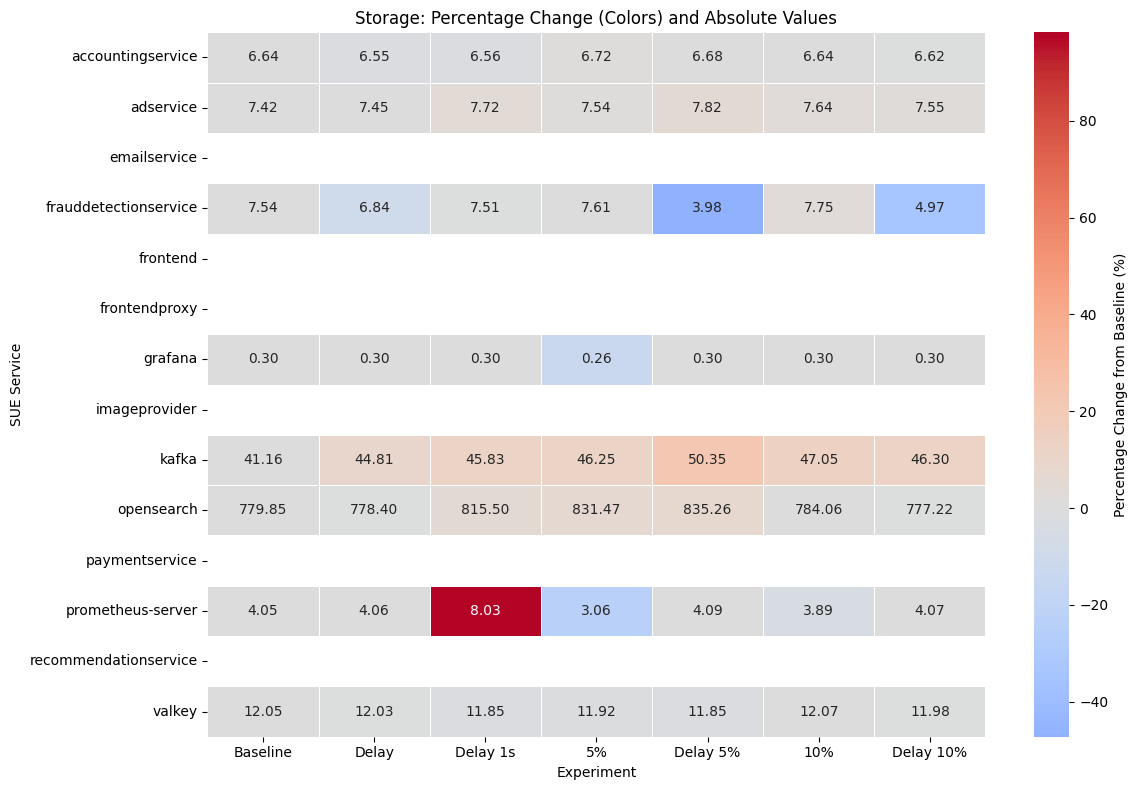

Container jaeger not found in all treatments.
Container opentelemetry-collector not found in all treatments.
{'Base Treatment': [6635520, 7421952, 0, 7544832, 0, 0, 303104, 0, 41156608, 779845632, 0, 4046848, 0, 12050432], 'Delay Treatment': [6553600, 7446528, 0, 6840320, 0, 0, 303104, 0, 44810240, 778403840, 0, 4055040, 0, 12034048], 'Delay 1s Treatment': [6561792, 7716864, 0, 7512064, 0, 0, 303104, 0, 45834240, 815497216, 0, 8028160, 0, 11845632], '5% Treatment': [6717440, 7544832, 0, 7610368, 0, 0, 262144, 0, 46252032, 831471616, 0, 3055616, 0, 11919360], 'Delay 5%': [6676480, 7815168, 0, 3981312, 0, 0, 303104, 0, 50348032, 835256320, 0, 4087808, 0, 11853824], '10%': [6635520, 7643136, 0, 7749632, 0, 0, 303104, 0, 47046656, 784056320, 0, 3891200, 0, 12066816], 'Delay 10%': [6619136, 7553024, 0, 4972544, 0, 0, 303104, 0, 46301184, 777224192, 0, 4071424, 0, 11984896]}
['accountingservice', 'adservice', 'emailservice', 'frauddetectionservice', 'frontend', 'frontendproxy', 'grafana', 'i

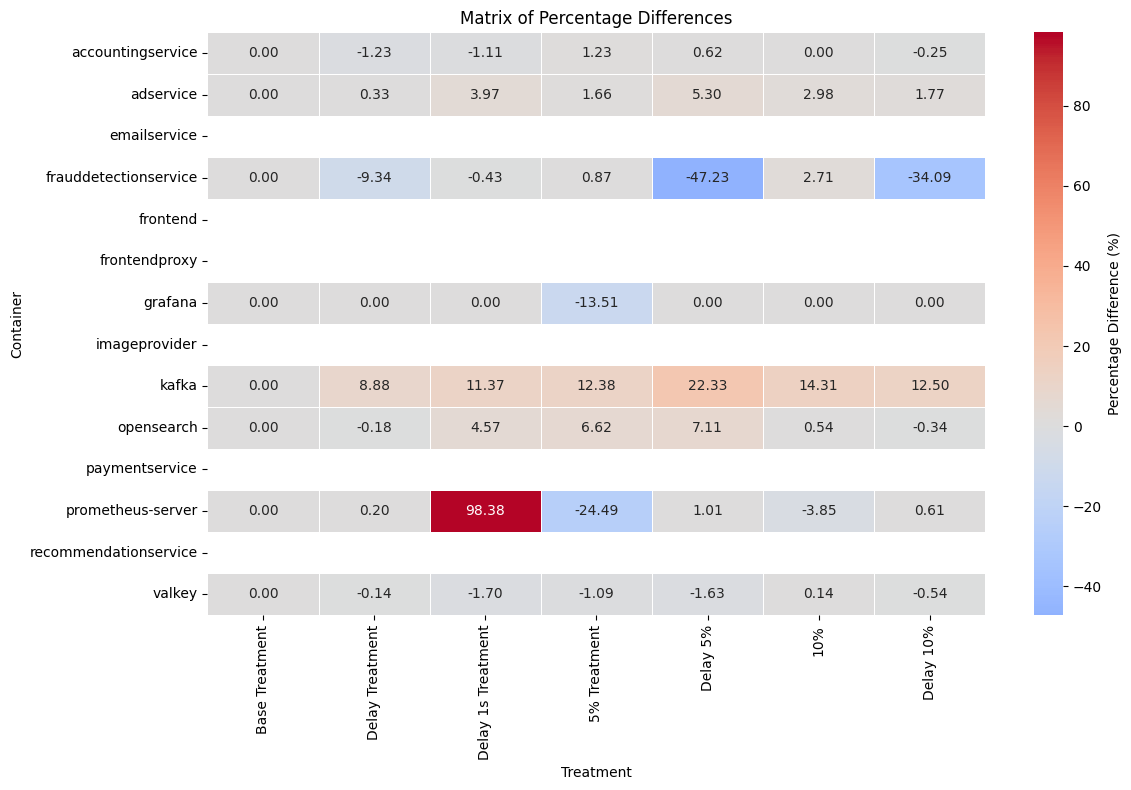

Container jaeger not found in all treatments.
Container opentelemetry-collector not found in all treatments.
{'Base Treatment': [6635520, 7421952, 0, 7544832, 0, 0, 303104, 0, 41156608, 779845632, 0, 4046848, 0, 12050432], 'Delay Treatment': [6553600, 7446528, 0, 6840320, 0, 0, 303104, 0, 44810240, 778403840, 0, 4055040, 0, 12034048], 'Delay 1s Treatment': [6561792, 7716864, 0, 7512064, 0, 0, 303104, 0, 45834240, 815497216, 0, 8028160, 0, 11845632], '5% Treatment': [6717440, 7544832, 0, 7610368, 0, 0, 262144, 0, 46252032, 831471616, 0, 3055616, 0, 11919360], 'Delay 5%': [6676480, 7815168, 0, 3981312, 0, 0, 303104, 0, 50348032, 835256320, 0, 4087808, 0, 11853824], '10%': [6635520, 7643136, 0, 7749632, 0, 0, 303104, 0, 47046656, 784056320, 0, 3891200, 0, 12066816], 'Delay 10%': [6619136, 7553024, 0, 4972544, 0, 0, 303104, 0, 46301184, 777224192, 0, 4071424, 0, 11984896]}
['accountingservice', 'adservice', 'emailservice', 'frauddetectionservice', 'frontend', 'frontendproxy', 'grafana', 'i

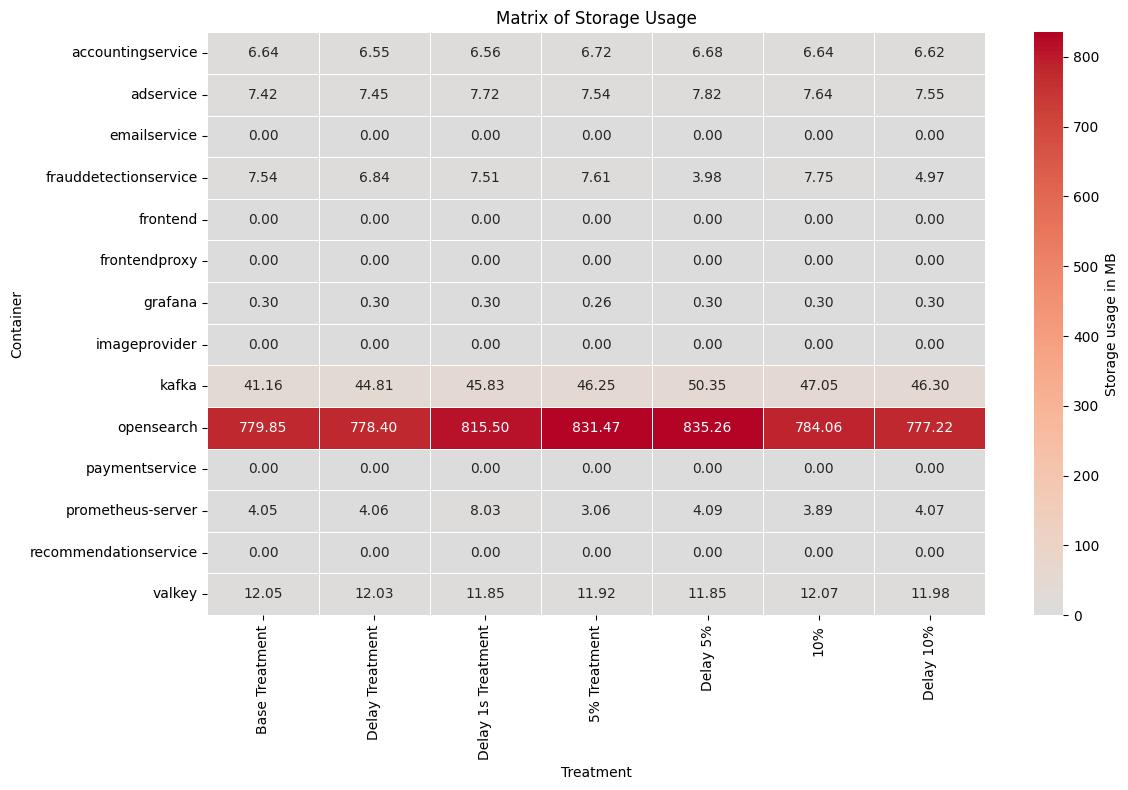

In [11]:
import math


def generate_difference_matrix_percentage(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay, 
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())

    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay 5%": [treatment_start_end_5percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "10%" : [treatment_start_end_10percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "Delay 10%": [treatment_start_end_10percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],

    }

    for c in containers:
        if c not in treatment_start_end_delay or c not in treatment_start_end_delay_1s or c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments.")
            containers.remove(c)
            continue

    print(data)
    print(containers)
    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment", "Delay 5%", "10%", "Delay 10%"]:
        percentage_difference[col] = (df[col] - df["Base Treatment"]) / df["Base Treatment"] * 100
        #print(f"Percentage difference for {col}: {percentage_difference[col]}")
        for i in range(len(percentage_difference[col])):
            if math.isinf(percentage_difference[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_difference[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Base Treatment'].iloc[i]}")
                percentage_difference.loc[containers[i], col] = math.nan

    #print(percentage_difference) 
    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix(
    treatment_start_end_base, 
    treatment_start_end_delay, 
    treatment_start_end_delay_1s, 
    treatment_start_end_5percent, 
    treatment_start_end_5percent_delay, 
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay
    ):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())

    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "Delay 5%": [treatment_start_end_5percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay],
        "10%" : [treatment_start_end_10percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "Delay 10%": [treatment_start_end_10percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_5percent_delay], 
    }

    for c in containers:
        if c not in treatment_start_end_delay or c not in treatment_start_end_delay_1s or c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments.")
            containers.remove(c)
            continue

    print(data)
    print(containers)
    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # from byte to MB
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment", "Delay 5%", "10%", "Delay 10%"]:
        percentage_difference[col] = df[col] / 1000 / 1000
        #print(f"Percentage difference for {col}: {percentage_difference[col]}")
        for i in range(len(percentage_difference[col])):
            if math.isinf(percentage_difference[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_difference[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Base Treatment'].iloc[i]}")
                percentage_difference.loc[containers[i], col] = math.nan

    #print(percentage_difference) 
    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Storage usage in MB'}
    )
    plt.title("Matrix of Storage Usage")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix_baseline(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
    treatment_start_end_delay_5percent,
    treatment_start_end_10percent_base,
    treatment_start_end_10percent_delay
):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Baseline": [treatment_start_end_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "Delay": [treatment_start_end_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "Delay 1s": [treatment_start_end_delay_1s[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "5%": [treatment_start_end_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent and c in treatment_start_end_delay_5percent],
        "Delay 5%": [treatment_start_end_delay_5percent[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "10%" : [treatment_start_end_10percent_base[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
        "Delay 10%": [treatment_start_end_10percent_delay[c][2] for c in containers if c in treatment_start_end_delay and c in treatment_start_end_delay_1s and c in treatment_start_end_5percent],
    }

    for c in containers:
        if c not in treatment_start_end_delay or c not in treatment_start_end_delay_1s or c not in treatment_start_end_5percent:
            print(f"Container {c} not found in all treatments. removing from list.")
            containers.remove(c)
            continue

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Convert byte to megabytes
    df_mb = df / 1000 / 1000
    
    # round to 2 decimal places
    df_mb = df_mb.round(2)

    # Compute percentage changes relative to "Baseline"
    percentage_changes = df_mb.subtract(df_mb["Baseline"], axis=0).div(df_mb["Baseline"], axis=0) * 100

    # Compute absolute differences (to show as annotations)
    absolute_difference = df_mb.subtract(df_mb["Baseline"], axis=0)

    print(percentage_changes)
    print(df_mb)

    #check if there are any infinite values 
    for col in percentage_changes.columns:
        for i in range(len(percentage_changes[col])):
            if math.isinf(percentage_changes[col].iloc[i]):
                print(f"NaN found in {col} {i} with value {percentage_changes[col].iloc[i]} for original values {df[col].iloc[i]} and {df['Baseline'].iloc[i]}")
                percentage_changes.loc[containers[i], col] = math.nan
    

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_changes,  # Percentage changes determine the colors
        annot=df_mb,  # Absolute differences are shown as annotations
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Change from Baseline (%)'}
    )
    plt.title("Storage: Percentage Change (Colors) and Absolute Values")
    plt.xlabel("Experiment")
    plt.ylabel("SUE Service")
    plt.tight_layout()
    plt.show()

generate_difference_matrix_baseline(
    values_base_storage_per_pod,
    values_delay_storage_per_pod,
    values_delay_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_delay_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_delay_10_percent_storage_per_pod,
)

generate_difference_matrix_percentage(
    values_base_storage_per_pod,
    values_delay_storage_per_pod,
    values_delay_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_delay_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_delay_10_percent_storage_per_pod,
)

generate_difference_matrix(
    values_base_storage_per_pod,
    values_delay_storage_per_pod,
    values_delay_1s_storage_per_pod,
    values_sampling_5_percent_storage_per_pod,
    values_delay_5_percent_storage_per_pod,
    values_base_10_percent_storage_per_pod,
    values_delay_10_percent_storage_per_pod,
)



In [ ]:
report_base_storage_per_namespace = load_report_interactions(report_directory, report_names[0], "cadvisor_storage_usage_combined_absolute", "empty_treatment")
report_delay_storage_per_namespace = load_report_interactions(report_directory, report_names[1], "cadvisor_storage_usage_combined_absolute", "delay_treatment")
report_delay_1s_storage_per_namespace = load_report_interactions(report_directory, report_names[2], "cadvisor_storage_usage_combined_absolute", "delay_treatment")
report_sampling_5_percent_storage_per_namespace = load_report_interactions(report_directory, report_names[3], "cadvisor_storage_usage_combined_absolute", "empty_treatment")
report_delay_5_percent_storage_per_namespace = load_report_interactions(report_directory, report_names[4], "cadvisor_storage_usage_combined_absolute", "delay_treatment")

[Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=TraceResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVariable), Interaction(treatment=EmptyTreatment, response=MetricResponseVari

In [ ]:
def get_storage_energy_consumption_per_namespace(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["container_label_io_kubernetes_pod_namespace"].unique())
    print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("container_label_io_kubernetes_pod_namespace"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]
    
        
        if not treatment_df.empty:
           # get the first and last value of the treatment
            treatment_start = treatment_df["cadvisor_storage_usage_combined_absolute"].iloc[0]
            treatment_end = treatment_df["cadvisor_storage_usage_combined_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")
            # set to 0 if no treatment period found
            treatment_start_end_values[container_name] = (-1, -1, -1)

    return treatment_start_end_values

values_base_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_base_storage_per_namespace, "empty_treatment")
values_delay_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_delay_storage_per_namespace, "delay_treatment")
values_delay_1s_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_delay_1s_storage_per_namespace, "delay_treatment")
values_sampling_5_percent_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_sampling_5_percent_storage_per_namespace, "empty_treatment")
values_delay_5_percent_storage_per_namespace = get_storage_energy_consumption_per_namespace(report_delay_5_percent_storage_per_namespace, "delay_treatment")

for container_name, values in values_base_storage_per_namespace.items():
    if not container_name in values_delay_storage_per_namespace or not container_name in values_delay_1s_storage_per_namespace or not container_name in values_sampling_5_percent_storage_per_namespace:
        print(f"Container {container_name} not found in all treatments.")
        continue
    percentage_differece_delay = (values_delay_storage_per_namespace[container_name][2] - values_base_storage_per_namespace[container_name][2]) / values_base_storage_per_namespace[container_name][2] * 100
    percentage_differece_delay_1s = (values_delay_1s_storage_per_namespace[container_name][2] - values_base_storage_per_namespace[container_name][2]) / values_base_storage_per_namespace[container_name][2] * 100
    percentage_differece_sampling = (values_sampling_5_percent_storage_per_namespace[container_name][2] - values_base_storage_per_namespace[container_name][2]) / values_base_storage_per_namespace[container_name][2] * 100
    percentage_differece_delay_5_percent = (values_delay_5_percent_storage_per_namespace[container_name][2] - values_base_storage_per_namespace[container_name][2]) / values_base_storage_per_namespace[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {values_base_storage_per_namespace[container_name][2]}")
    print(f"Delay Treatment: {values_delay_storage_per_namespace[container_name][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {values_delay_1s_storage_per_namespace[container_name][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"Sampling 5% Treatment: {values_sampling_5_percent_storage_per_namespace[container_name][2]} ({percentage_differece_sampling:.2f}%)")
    print(f"Delay 5% Treatment: {values_delay_5_percent_storage_per_namespace[container_name][2]} ({percentage_differece_delay_5_percent:.2f}%)")
    
    print("-----------------------------------------------")

Interaction: empty_treatment with 1 containers
Interaction: delay_treatment with 1 containers
Interaction: delay_treatment with 1 containers
Interaction: empty_treatment with 1 containers
Interaction: delay_treatment with 1 containers
Container: system-under-evaluation
Base Treatment: 102916096
Delay Treatment: 112254976 (9.07%)
Delay 1s Treatment: 117686272 (14.35%)
Sampling 5% Treatment: 562708480 (446.76%)
Delay 5% Treatment: 117415936 (14.09%)
-----------------------------------------------
